In [2]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import date_format, date_add, col, avg
import matplotlib.pyplot as plt
from pyspark.sql.functions import coalesce, lit

Create Spark Session

In [3]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") 
    .config('spark.executor.memoryOverhead', '3000')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/19 23:36:46 WARN Utils: Your hostname, LAPTOP-RELH58H1 resolves to a loopback address: 127.0.1.1; using 172.19.22.4 instead (on interface eth0)
23/08/19 23:36:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 23:36:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Load in taxi data

In [7]:
# Define a list of 3-month segments
segments = [
    "2016_01_to_03", "2016_04_to_06", "2016_07_to_09", "2016_10_to_12",
    "2017_01_to_03", "2017_04_to_06", "2017_07_to_09", "2017_10_to_12",
    "2018_01_to_03", "2018_04_to_06", "2018_07_to_09", "2018_10_to_12",
    "2019_01_to_03", "2019_04_to_06", "2019_07_to_09", "2019_10_to_12"
]

# Create a list to store the DataFrames
sdf_yellow_segments = []

# Create DataFrames for each segment and add to the list
for segment in segments:
    segment_df = spark.read.parquet(f'../data/raw/yellow_taxi_hourly/{segment}.parquet/*')
    sdf_yellow_segments.append(segment_df)


Rename pick up location column

In [8]:
# Renaming the column in each DataFrame in the list
for i in range(len(sdf_yellow_segments)):
    sdf_yellow_segments[i] = sdf_yellow_segments[i].withColumnRenamed("PULocationID", "LocationID")

Load Shooting Taxi Trips

In [9]:
# Define a list of 3-month segments
segments = [
    "2016_01_to_03", "2016_04_to_06", "2016_07_to_09", "2016_10_to_12",
    "2017_01_to_03", "2017_04_to_06", "2017_07_to_09", "2017_10_to_12",
    "2018_01_to_03", "2018_04_to_06", "2018_07_to_09", "2018_10_to_12",
    "2019_01_to_03", "2019_04_to_06", "2019_07_to_09", "2019_10_to_12"
]

# Create a list to store the DataFrames
sdf_shooting_trip_segments = []

# Create DataFrames for each segment and add to the list
for segment in segments:
    segment_df = spark.read.parquet(f'../data/curated/shooting_taxi_hour_data_reduced/{segment}.parquet/*')
    sdf_shooting_trip_segments.append(segment_df)
    

Rename pickup_hour as Hour

In [21]:
rename_df = []
for df in sdf_shooting_trip_segments:
    # Rename the pickup_hour column to Hour
    df = df.withColumnRenamed("pickup_hour", "Hour")
    rename_df.append(df)
    
sdf_shooting_trip_segments = rename_df

Function to calculate the average pickups per hour for each location

In [22]:
# Define a function to calculate the average pickups per hour for each location
def calculate_average_pickups_per_location(dataframes):
    """
    Calculate the average number of pickups per hour for each location across multiple DataFrames.
    Inputs:
        List of DataFrames containing pickup data.
    Returns:
        List of DataFrames containing average pickups per hour for each location.
    """
    # Initialize an empty list to store the averages
    averages_per_location = []

    # Loop through each DataFrame in the list
    for df in dataframes:
        # Calculate the average pickups per hour for each location
        average_location_df = df.groupBy("LocationID", "Hour").agg(avg("number_of_trips").alias("avg_pickups_per_hour"))
        averages_per_location.append(average_location_df)

    return averages_per_location

Use function to run calculations

In [23]:
# Assuming sdf_yellow_segments and sdf_shooting_trip_segments are DataFrames in your list
# Calculate average pickups per hour for each location for both lists of DataFrames
average_pickups_per_location_yellow = calculate_average_pickups_per_location(sdf_yellow_segments)
average_pickups_per_location_shooting = calculate_average_pickups_per_location(sdf_shooting_trip_segments)

# Display the calculated averages for each location
for idx, (average_yellow, average_shooting) in enumerate(zip(average_pickups_per_location_yellow, average_pickups_per_location_shooting)):
    print(f"Averages per Location for DataFrame {idx + 1}:")
    print("Average Pickups per Hour (Yellow Taxi):")
    print("Average Pickups per Hour (Shooting Data):")
    average_shooting.show()

Averages per Location for DataFrame 1:
Average Pickups per Hour (Yellow Taxi):
Average Pickups per Hour (Shooting Data):
+----------+----+--------------------+
|LocationID|Hour|avg_pickups_per_hour|
+----------+----+--------------------+
|       177|   1|                1.75|
|       216|   2|  1.3333333333333333|
|       193|   9|   8.571428571428571|
|        28|  12|                1.25|
|        10|  14|  3.4444444444444446|
|       152|  14|                16.0|
|       235|  17|                 1.5|
|       227|  22|                1.75|
|       212|   1|                 1.0|
|       219|  18|                 2.5|
|       136|   4|                 2.0|
|       185|   7|                 1.0|
|       247|   0|  2.2857142857142856|
|       258|   1|                 1.0|
|        89|   4|                 2.9|
|        89|  19|  2.9166666666666665|
|       188|  20|                3.75|
|       195|   5|                 1.0|
|        55|  18|                 1.0|
|        28|  11|  1.

In [25]:
# Calculate the difference in average trips per hour for shooting and non-shooting conditions
differences = []
for df_yellow, df_shooting in zip(average_pickups_per_location_yellow, average_pickups_per_location_shooting):
    location_id = df_yellow.select("LocationID").first()["LocationID"]
    
    # Coalesce to handle missing values and fill with 0
    difference_df = df_shooting.join(df_yellow, ["LocationID", "Hour"], "outer").withColumn(
        "difference",
        coalesce(df_shooting["avg_pickups_per_hour"], lit(0)) - coalesce(df_yellow["avg_pickups_per_hour"], lit(0))
    ).select("Hour", "difference")
    
    differences.append((location_id, difference_df))

# Combine the DataFrames containing average pickups per location and hour
combined_data = average_pickups_per_location_yellow + average_pickups_per_location_shooting

Now get the difference in trip differences for each location 

In [26]:
# Calculate the difference in average trips per hour for each location
differences = []
for df_yellow, df_shooting in zip(average_pickups_per_location_yellow, average_pickups_per_location_shooting):
    location_id = df_yellow.select("LocationID").first()["LocationID"]
    
    # Coalesce to handle missing values and fill with 0
    difference_df = df_shooting.join(df_yellow, ["Hour"], "outer").withColumn(
        "difference",
        coalesce(df_shooting["avg_pickups_per_hour"], lit(0)) - coalesce(df_yellow["avg_pickups_per_hour"], lit(0))
    ).select("Hour", "difference")
    
    differences.append((location_id, difference_df))

Create plot of shooting difference between before and after shootings at the location

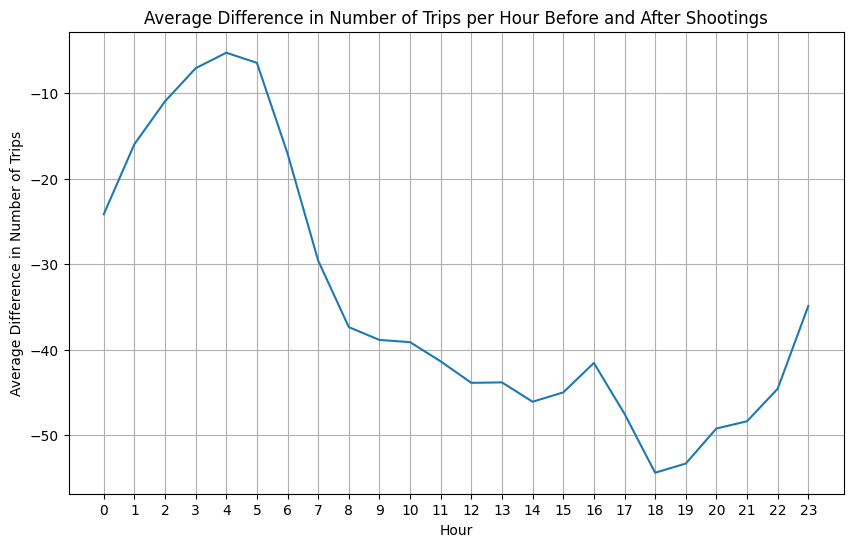

In [30]:
# Calculate the average difference for each hour over all locations
hourly_avg_differences = [0] * 24
num_locations = len(differences)
for _, difference_df in differences:
    pandas_df = difference_df.toPandas()
    hourly_avg_differences += pandas_df.groupby("Hour")["difference"].mean()

hourly_avg_differences /= num_locations

# Plot the average differences
plt.figure(figsize=(10, 6))
plt.plot(range(24), hourly_avg_differences)
plt.xlabel("Hour")
plt.ylabel("Average Difference in Number of Trips")
plt.title("Average Difference in Number of Trips per Hour Before and After Shootings")
plt.xticks(range(24))
plt.grid(True)

# Save the plot as an image
plt.savefig("../plots/shooting_hourly_effects_plot.png")

# Display plot
plt.show()

# Stop the SparkSession
spark.stop()